Reference: https://mc-stan.org/users/documentation/case-studies/soil-knit.html  
Dataset: "SoilR" library in R

In [1]:
import stan
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio; nest_asyncio.apply()
import pandas as pd; pd.set_option("mode.chained_assignment", None)
from utils import select_columns, plot_ESS, plot_GR, plot_posterior

df = pd.read_csv("../data/eCO2.csv", index_col=0)
display(df)

,Days,eCO2mean,eCO2sd
1,1,34.94853,1.974138
2,3,30.04433,1.219752
3,5,27.31103,1.815506
4,7,21.04280,1.384572
5,9,21.84829,1.399500
6,11,19.71887,0.698634
7,13,19.26134,1.284670
8,15,19.59110,0.924188
9,17,19.32115,1.222801
10,19,18.72907,1.098853


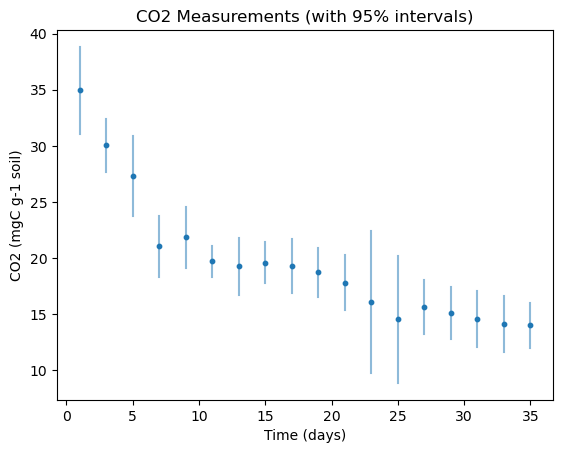

In [2]:
totalC_t0 = 35  # not included in data
t0 = 0
N_t = 18
ts = df["Days"].to_numpy()
eCO2mean = df["eCO2mean"].to_numpy() 
eCO2sd = df["eCO2sd"].to_numpy()

plt.scatter(ts, eCO2mean, color="tab:blue", s=10)
for i, (ymin, ymax) in enumerate(zip(eCO2mean - 1.96 * eCO2sd, eCO2mean + 1.96 * eCO2sd)):
  plt.plot([ts[i], ts[i]], [ymin, ymax], color="tab:blue", alpha=0.5)
plt.title("CO2 Measurements (with 95% intervals)")
plt.ylabel("CO2 (mgC g-1 soil)")
plt.xlabel("Time (days)")
plt.show()

In [3]:
num_chains = 4
num_samples = 1000
data = {"totalC_t0": totalC_t0,
        "t0": t0,
        "N_t": N_t,
        "ts": ts,
        "eCO2mean": eCO2mean,
        "eCO2sd": eCO2sd}

In [5]:
ode_system = """
functions { 

  /** 
   * ODE system for two pool model with feedback and no inputs. 
   * System State C is two dimensional with C[1] and C[2]  
   * being carbon in pools 1 and 2. 
   * The system has parameters 
   * 
   *   theta = (k1, k2, alpha21, alpha12) 
   * 
   * where 
   * 
   *   k1:       pool 1 decomposition rate 
   *   k2:       pool 2 decomposition rate 
   *   alpha21:  transfer coefficient from pool 2 to pool 1 
   *   alpha12:  transfer coefficient from pool 1 to pool 2 
   * 
   * The system time derivatives are 
   * 
   *   d.C[1] / d.t  =  -k1 * C[1]  +  alpha21 * k2 * C[2] 
   *   d.C[2] / d.t  =  -k2 * C[2]  +  alpha12 * k1 * C[1] 
   * 
   * @param t time at which derivatives are evaluated. 
   * @param C system state at which derivatives are evaluated. 
   * @param theta parameters for system. 
   * @param x_r real constants for system (empty). 
   * @param x_i integer constants for system (empty). 
   */ 

  array[] real two_pool_feedback(real t, array[] real C, array[] real theta, 
                           array[] real x_r, array[] int x_i) { 
    real k1; 
    real k2; 
    real alpha21; 
    real alpha12; 
 
    array[2] real dC_dt; 
 
    k1 = theta[1]; 
    k2 = theta[2]; 
    alpha21 = theta[3]; 
    alpha12 = theta[4]; 
     
    dC_dt[1] = -k1 * C[1] + alpha21 * k2 * C[2]; 
    dC_dt[2] = -k2 * C[2] + alpha12 * k1 * C[1] ; 
 
    return dC_dt; 
  } 
 
  /** 
   * Compute total evolved CO2 from the system given the specified 
   * parameters and times.  This is done by simulating the system 
   * defined by the ODE function two_pool_feedback and then 
   * subtracting the sum of the CO2 estimated in each pool from the 
   * initial CO2. 
   * 
   * @param T number of times. 
   * @param t0 initial time. 
   * @param ts observation times. 
   * @param gamma partitioning coefficient. 
   * @param k1 decomposition rate for pool 1 
   * @param k2 decomposition rate for pool 2 
   * @param alpha21 transfer coefficient from pool 2 to 1 
   * @param alpha12 transfer coefficient from pool 1 to 2 
   * @param x_r real data (empty) 
   * @param x_i integer data (empty) 
   * @return evolved CO2 for times ts 
   */ 

  array[] real evolved_CO2(int N_t, real t0, array[] real ts, 
                     real gamma, real totalC_t0, 
                     real k1, real k2,  
                     real alpha21, real alpha12, 
                     data array[] real x_r, data array[] int x_i) { 
 
    array[2] real C_t0;               // initial state 
    array[4] real theta;              // ODE parameters 
    array[N_t, 2] real C_pred;        // predicted pool content 
    array[N_t] real eCO2_pred; 
 
    C_t0[1] = gamma * totalC_t0; 
    C_t0[2] = (1 - gamma) * totalC_t0; 
 
    theta[1] = k1; 
    theta[2] = k2; 
    theta[3] = alpha21; 
    theta[4] = alpha12; 
 
    C_pred = integrate_ode_rk45(two_pool_feedback,  
                           C_t0, t0, ts, theta, x_r, x_i); 
 
    for (t in 1:N_t) 
      eCO2_pred[t] = sum(C_pred[t]); 
    return eCO2_pred; 
  } 
  
}
"""

In [6]:
soil_carbon_centered = ode_system + """
data { 
  real<lower=0> totalC_t0;           // initial total carbon 
  real t0;                           // initial time 
  int<lower=0> N_t;                  // number of measurement times 
  array[N_t] real<lower=t0> ts;      // measurement times 
  vector<lower=0>[N_t] eCO2mean;     // measured cumulative evolved carbon 
  vector<lower=0>[N_t] eCO2sd;       // measured standard devation
} 
transformed data { 
  array[0] real x_r;                 // no real data for ODE system 
  array[0] int x_i;                  // no integer data for ODE system 
} 
parameters { 
  real k1;                     // pool 1 decomposition rate 
  real k2;                     // pool 2 decomposition rate 
  real alpha21;                // transfer coeff from pool 2 to 1 
  real alpha12;                // transfer coeff from pool 1 to 2 
  real<lower=0,upper=1> gamma; // partitioning coefficient 
  real<lower=0> sigma;         // observation std dev 
  vector[N_t] eCO2;            // evolved CO2 
} 
transformed parameters { 
  array[N_t] real eCO2_pred = evolved_CO2(N_t, t0, ts, gamma, totalC_t0, 
                                          k1, k2, alpha21, alpha12, x_r, x_i); 
} 
model { 
  // priors 
  gamma ~ beta(10,1);         // identifies pools 
  k1 ~ normal(0,1);           // weakly informative 
  k2 ~ normal(0,1); 
  alpha21 ~ normal(0,1); 
  alpha12 ~ normal(0,1); 
  sigma ~ cauchy(0,1); 
  eCO2 ~ normal(eCO2_pred, sigma);  // normal error 
 
  // likelihood 
  eCO2mean ~ normal(eCO2, eCO2sd);  // measurement error
}
"""

posterior_centered = stan.build(soil_carbon_centered, data=data)
fit_centered = posterior_centered.sample(num_chains=num_chains, num_samples=num_samples)
df_centered = fit_centered.to_frame()
df_centered.to_csv("result/soil_carbon_centered.csv")

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:5,
                 from /home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/sangho/.cache/httpstan/4.8.2/models/xapcv56j/model_xapcv56j.cpp:2:
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:401:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  401 |   using pair_type = std::pair<int, arena_vec>;
      |         ^~~~~~~~~


Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.9s


/home/sangho/.cache/httpstan/4.8.2/models/xapcv56j/model_xapcv56j.cpp: In instantiation of ‘void model_xapcv56j_namespace::model_xapcv56j::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/sangho/.cache/httpstan/4.8.2/models/xapcv56j/model_xapcv56j.cpp:790:69:   required from here
/home/sangho/.cache/httpstan/4.8.2/models/xapcv56j/model_xapcv56j.cpp:578:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  578 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.5s
Building: 1

Building: 18.5s, done.
Messages from stanc:
Warning in '/tmp/httpstan_3lvoao3k/model_xapcv56j.stan', line 90, column 13: integrate_ode_rk45
    is deprecated and will be removed in Stan 3.0. Use ode_rk45 instead. 
    The new interface is slightly different, see:
    https://mc-stan.org/users/documentation/case-studies/convert_odes.html
Warning in '/tmp/httpstan_3lvoao3k/model_xapcv56j.stan', line 90, column 32: The
    variable two_pool_feedback may not have been assigned a value before its
    use.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (102/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Samplin

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of t

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/h

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of t

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/h

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of t

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan',

  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejecte

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_phv9keed/model_xapcv56j.stan', line 136, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

In [21]:
soil_carbon_noncentered = ode_system + """
data { 
  real<lower=0> totalC_t0;           // initial total carbon 
  real t0;                           // initial time 
  int<lower=0> N_t;                  // number of measurement times 
  array[N_t] real<lower=t0> ts;      // measurement times 
  vector<lower=0>[N_t] eCO2mean;     // measured cumulative evolved carbon 
  vector<lower=0>[N_t] eCO2sd;       // measured standard devation
} 
transformed data { 
  array[0] real x_r;                 // no real data for ODE system 
  array[0] int x_i;                  // no integer data for ODE system 
} 
parameters { 
  real k1;                     // pool 1 decomposition rate 
  real k2;                     // pool 2 decomposition rate 
  real alpha21;                // transfer coeff from pool 2 to 1 
  real alpha12;                // transfer coeff from pool 1 to 2 
  real<lower=0,upper=1> gamma; // partitioning coefficient 
  real<lower=0> sigma;         // observation std dev 
  vector[N_t] eCO2_hat;        // reparameterised eCO2
} 
transformed parameters { 
  array[N_t] real eCO2_pred = evolved_CO2(N_t, t0, ts, gamma, totalC_t0, 
                                          k1, k2, alpha21, alpha12, x_r, x_i); 
  vector[N_t] eCO2 = to_vector(eCO2_pred) + (eCO2_hat * sigma);
} 
model { 
  // priors 
  gamma ~ beta(10,1);         // identifies pools 
  k1 ~ normal(0,1);           // weakly informative 
  k2 ~ normal(0,1); 
  alpha21 ~ normal(0,1); 
  alpha12 ~ normal(0,1); 
  sigma ~ cauchy(0,1); 
  eCO2_hat ~ normal(0,1);
 
  // likelihood 
  eCO2mean ~ normal(eCO2, eCO2sd);
}
"""

posterior_noncentered = stan.build(soil_carbon_noncentered, data=data)
fit_noncentered = posterior_noncentered.sample(num_chains=num_chains, num_samples=num_samples)
df_noncentered = fit_noncentered.to_frame()
df_noncentered.to_csv("result/soil_carbon_noncentered.csv")

Building: 0.2s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.1s
Building: 

In file included from /home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:5,
                 from /home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/sangho/.cache/httpstan/4.8.2/models/m4kq6nst/model_m4kq6nst.cpp:2:
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:401:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  401 |   using pair_type = std::pair<int, arena_vec>;
      |         ^~~~~~~~~


Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s


/home/sangho/.cache/httpstan/4.8.2/models/m4kq6nst/model_m4kq6nst.cpp: In instantiation of ‘void model_m4kq6nst_namespace::model_m4kq6nst::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/sangho/.cache/httpstan/4.8.2/models/m4kq6nst/model_m4kq6nst.cpp:839:69:   required from here
/home/sangho/.cache/httpstan/4.8.2/models/m4kq6nst/model_m4kq6nst.cpp:614:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  614 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 1

Building: 18.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_d6o7j7wz/model_m4kq6nst.stan', line 90, column 13: integrate_ode_rk45
    is deprecated and will be removed in Stan 3.0. Use ode_rk45 instead. 
    The new interface is slightly different, see:
    https://mc-stan.org/users/documentation/case-studies/convert_odes.html
Warning in '/tmp/httpstan_d6o7j7wz/model_m4kq6nst.stan', line 90, column 32: The
    variable two_pool_feedback may not have been assigned a value before its
    use.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (102/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of t

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/h

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of t

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/h

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 90, column 4 to line 91, column 58) (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 123, column 2 to line 124, column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: Exception: integrate_ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps s

  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejecte

  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejecte

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan', line 139, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/tmp/httpstan_g41s3r10/model_m4kq6nst.stan',

In [4]:
df_centered = pd.read_csv("result/soil_carbon_centered.csv")
df_noncentered = pd.read_csv("result/soil_carbon_noncentered.csv")
dfs = [df_centered, df_noncentered]
labels = ["centered", "noncentered"]

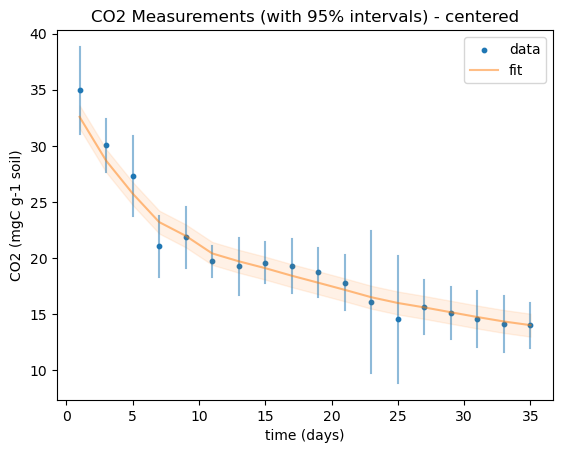

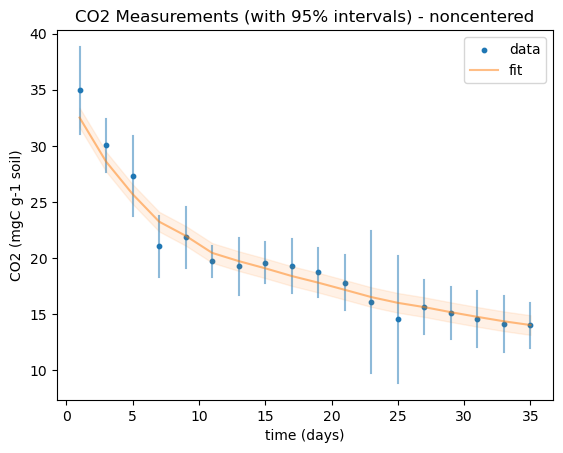

In [9]:
for df, label in zip(dfs, labels):
    plt.scatter(ts, eCO2mean, color="tab:blue", s=10, label="data")
    for i, (ymin, ymax) in enumerate(zip(eCO2mean - 1.96 * eCO2sd, eCO2mean + 1.96 * eCO2sd)):
      plt.plot([ts[i], ts[i]], [ymin, ymax], color="tab:blue", alpha=0.5)

    mean = select_columns(df, "eCO2.").to_numpy().mean(axis=0)
    sigma = df["sigma"].to_numpy().mean()
    plt.plot(ts, mean, color="tab:orange", alpha=0.5, label="fit")
    plt.fill_between(ts, mean - 1.96 * sigma, mean + 1.96 * sigma, color="tab:orange", alpha=0.1)

    plt.title(f"CO2 Measurements (with 95% intervals) - {label}")
    plt.ylabel("CO2 (mgC g-1 soil)")
    plt.xlabel("time (days)")
    plt.legend()
    plt.show()

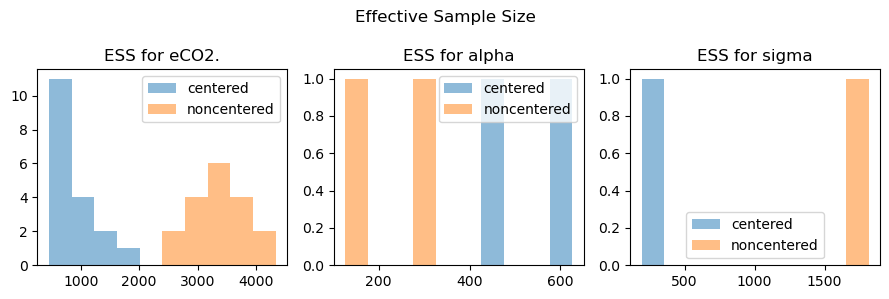

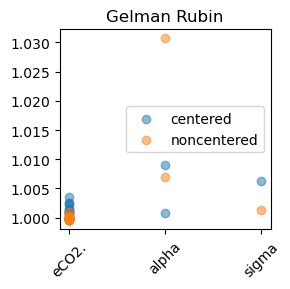

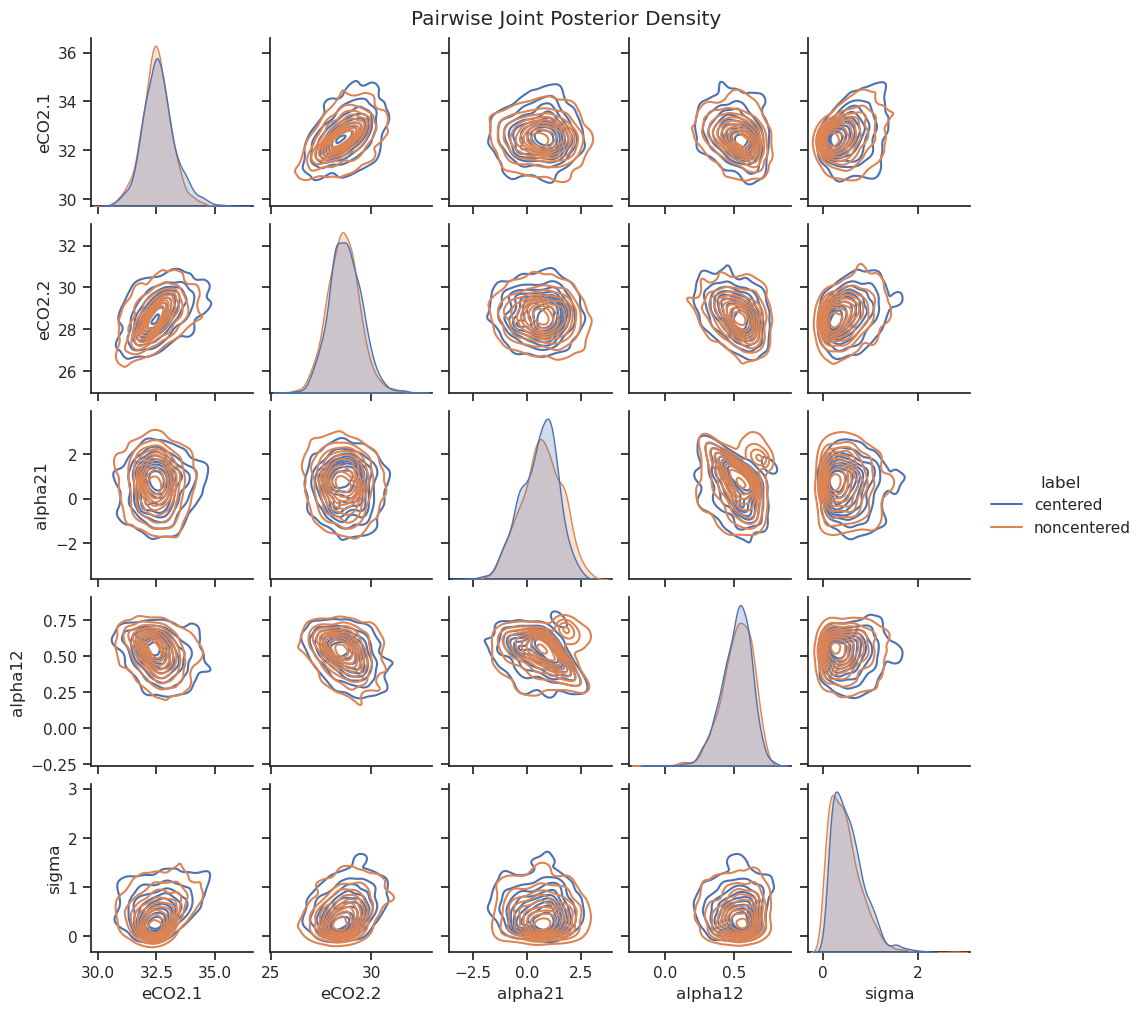

In [11]:
plot_ESS(dfs, labels,
         params=["eCO2.", "alpha", "sigma"],
         num_chains=num_chains, num_samples=num_samples)

plot_GR(dfs, labels,
        params=["eCO2.", "alpha", "sigma"],
        num_chains=num_chains, num_samples=num_samples)

plot_posterior(dfs, labels,
               params=["eCO2.1", "eCO2.2", "alpha21", "alpha12", "sigma"],
               num_subsamples=1000)